In [2]:
import findspark
findspark.init("/u/cs451/packages/spark")

from pyspark.sql import SparkSession
import random
spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [50]:
# import libraries
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn
import re
from pyspark.sql.window import Window

In [4]:
# read file
df = spark.read\
.option("wholeFile", True)\
.option("inferSchema", True)\
.option("header", True)\
.option("multiline", True)\
.option('quote', '"')\
.option('escape', '"')\
.csv("alldata.csv")

df = df.na.fill({'reviews': 0})
df = df.filter("position is not NULL")

In [5]:
# divide positions into Data Scientist, Data Analyst, Engineer
df_new=df.withColumn("position2", when(lower(df["position"]).like('%scientist%') |\
                                       #lower(df["position"]).like('%science%') |\
                                       #lower(df["position"]).like('%professor%') |\
                                       lower(df["position"]).like('%science%'), lit("Data Scientist"))\
   .when(lower(df["position"]).like('%analyst%') |\
         #lower(df["position"]).like('%analysis%') |\
         lower(df["position"]).like('%analytics%') |\
         lower(df["position"]).like('%analysis%'), lit("Data Analyst"))\
   .when(lower(df["position"]).like('%engineer%'), lit("Engineer"))\
   .otherwise(lit("Others")))

In [6]:
# divide reviews into Small, Medium, Large
df_new1=df_new.withColumn("company size", when(df["reviews"] <= 50, lit("Small"))\
                          .when(df["reviews"]<= 700, lit("Medium"))\
                          .otherwise(lit("Large")))

In [7]:
# unselect position2 = "Others"
df_new2=df_new1.filter(df_new["position2"] != "Others")

In [8]:
# drop unrelated columns
drop_list = ['position', 'company', 'reviews', 'location\r', 'company size']
df_new3 = df_new2.select([column for column in df_new1.columns if column not in drop_list])
df_new3.columns

['description', 'position2']

In [9]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [10]:
add_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", \
                 "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", \
                 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', \
                 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', \
                 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', \
                 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', \
                 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', \
                 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', \
                 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', \
                 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", \
                 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", \
                 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", \
                 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', \
                 "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', \
                 "won't", 'wouldn', "wouldn't"]

In [151]:
# remove punctuation etc.
df_new3_clean = df_new3.select((lower(regexp_replace('description', "[^\w\s\/\']", "")).alias('description')), 'position2')
df_new3_clean1 = df_new3_clean.select((lower(regexp_replace('description', "[^\w\s]|\n|\n\n", " ")).alias('description')), 'position2')
df_new3_clean2 = df_new3_clean1.select((lower(regexp_replace('description', "\s\s+", " ")).alias('description')), 'position2')

In [ ]:
df_new3_clean2.show(5)

# Degree vs Job Type

In [121]:
degree_list = ['master',"masters",'phd','bachelor',"bachelors",
             'No degree requirement', 'ba','bs','ma','ms','undergraduate','graduate']

degree_list1 = ['master',"master",'phd','bachelor',"bachelor",
             'no_degree_requirement', 'bachelor','bachelor','master','master','bachelor','master']

for degree in degree_list:
    #print(skills_list1[skills_list.index(skill)])
    df_new3_clean2 = df_new3_clean2.select((lower(regexp_replace('description', \
                                                                 degree, \
                                                                 degree_list1[degree_list.index(degree)])).alias('description')), 'position2')

In [122]:
regexTokenizer = Tokenizer(inputCol="description", outputCol="words")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_new3_clean2)
dataset = pipelineFit.transform(df_new3_clean2)

In [ ]:
dataset.show(5)

In [123]:
terms_ds=dataset.filter(col('position2') == 'Data Scientist').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

terms_da=dataset.filter(col('position2') == 'Data Analyst').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

terms_e=dataset.filter(col('position2') == 'Engineer').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

In [124]:
# degree_list ranking
pandas_df1=terms_ds.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(degree_list1) + ')(\s|$)')).toPandas()
pandas_df2=terms_da.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(degree_list1) + ')(\s|$)')).toPandas()
pandas_df3=terms_e.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(degree_list1) + ')(\s|$)')).toPandas()

In [126]:
pandas_df1['count']=pandas_df1['count']/2884
pandas_df2['count']=pandas_df2['count']/993
pandas_df3['count']=pandas_df3['count']/1151
pandas_df1

TermFre     count
0       phd  0.650832
1    master  0.438974
2  bachelor  0.193828

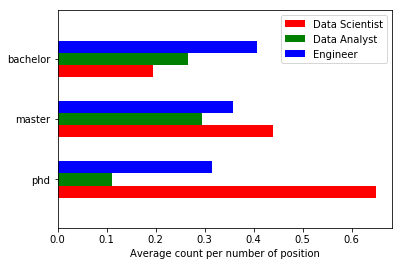

In [129]:
import numpy as np
ind = np.arange(3)
width = 0.2

fig, ax = plt.subplots()
ax.barh(ind, pandas_df1['count'], width, color='red', label='Data Scientist')
ax.barh(ind + width, pandas_df2['count'], width, color='green', label='Data Analyst')
ax.barh(ind + width + width, pandas_df3['count'], width, color='blue', label='Engineer')

ax.set(yticks=ind + width, yticklabels=pandas_df3['TermFre'], ylim=[2*width - 1, 3])
ax.set_xlabel('Average count per number of position')
ax.legend()

plt.show()

# Major vs Job Type

In [152]:
major_list = ['computer science','statistics','mathematics','biology','chemistry','economics']

major_list1 = ['computer_science','statistics','mathematics','biology','chemistry','economics']

for major in major_list:
    #print(skills_list1[skills_list.index(skill)])
    df_new3_clean2 = df_new3_clean2.select((lower(regexp_replace('description', \
                                                                 major, \
                                                                 major_list1[major_list.index(major)])).alias('description')))
    
regexTokenizer = Tokenizer(inputCol="description", outputCol="words")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_new3_clean2)
dataset = pipelineFit.transform(df_new3_clean2)

terms_ds=dataset.filter(col('position2') == 'Data Scientist').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

terms_da=dataset.filter(col('position2') == 'Data Analyst').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

terms_e=dataset.filter(col('position2') == 'Engineer').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)
    
# major_list ranking
pandas_df1=terms_ds.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(major_list1) + ')(\s|$)')).toPandas()
pandas_df2=terms_da.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(major_list1) + ')(\s|$)')).toPandas()
pandas_df3=terms_e.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(major_list1) + ')(\s|$)')).toPandas()

In [153]:
pandas_df1['count']=pandas_df1['count']/2884
pandas_df2['count']=pandas_df2['count']/993
pandas_df3['count']=pandas_df3['count']/1151
pandas_df1

TermFre     count
0         chemistry  0.228155
1  computer_science  0.444868
2       mathematics  0.293343
3           biology  0.509709
4         economics  0.132108
5        statistics  0.633148

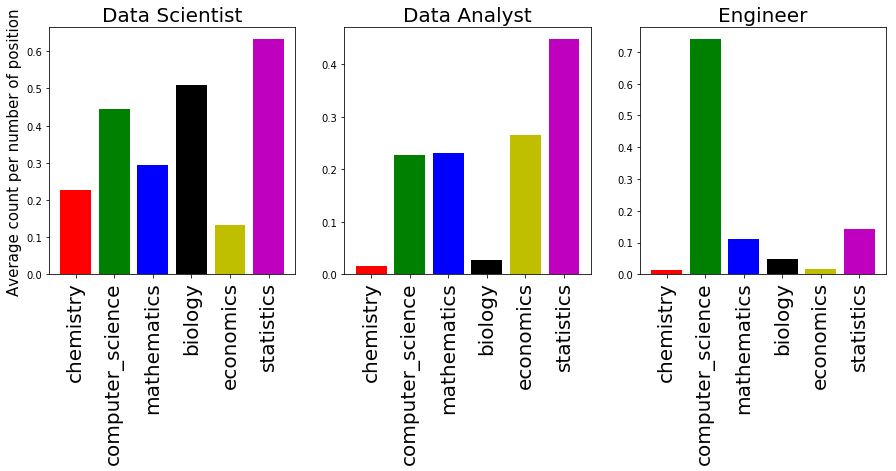

In [157]:
from matplotlib.gridspec import GridSpec

# Make square figures and axes
plt.figure(1, figsize=(15,10))
the_grid = GridSpec(2, 3)
index = np.arange(6)
my_colors = 'rgbkymc'

ax=plt.subplot(the_grid[0, 0], title='Data Scientist')
plt.bar(index, pandas_df1['count'], align='center', color=my_colors)
plt.xticks(index, pandas_df1['TermFre'], rotation=90, fontsize=20)
plt.ylabel('Average count per number of position', fontsize=15)
ax.set_title('Data Scientist',fontsize= 20)

ax=plt.subplot(the_grid[0, 1], title='Data Analyst')
plt.bar(index, pandas_df2['count'], align='center', color=my_colors)
plt.xticks(index, pandas_df2['TermFre'], rotation=90, fontsize=20)
ax.set_title('Data Analyst',fontsize= 20)

ax=plt.subplot(the_grid[0, 2], title='Engineer')
plt.bar(index, pandas_df3['count'], align='center', color=my_colors)
plt.xticks(index, pandas_df3['TermFre'], rotation=90, fontsize=20)
ax.set_title('Engineer',fontsize= 20)

#plt.suptitle('Major Difference in Three Job Types', fontsize=16)
plt.show()

# Skills vs Job Types

In [61]:
skills_list = ['machine learning','ml','modeling','deep learning',
               'optimization','decision tree','logistic','random forest','neural network',
               'artificial intelligence', 'ai'
               'data analysis','data visualization','statistical analysis']

skills_list1 = ['machine_learning/modeling/deep_learning',
                'machine_learning/modeling/deep_learning',
                'machine_learning/modeling/deep_learning',
                'machine_learning/modeling/deep_learning',
                'machine_learning/modeling/deep_learning',
                'machine_learning/modeling/deep_learning',
                'machine_learning/modeling/deep_learning',
                'machine_learning/modeling/deep_learning',
                'machine_learning/modeling/deep_learning',
                'artificial_intelligence',
                'artificial_intelligence',
                'data_analysis/data_visualization',
                'data_analysis/data_visualization',
                'data_analysis/data_visualization']

for skill in skills_list:
    #print(skills_list1[skills_list.index(skill)])
    df_new3_clean2 = df_new3_clean2.select((lower(regexp_replace('description', \
                                                                 skill, \
                                                                 skills_list1[skills_list.index(skill)])).alias('description')))
    

regexTokenizer = Tokenizer(inputCol="description", outputCol="words")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_new3_clean2)
dataset = pipelineFit.transform(df_new3_clean2)

terms_ds=dataset.filter(col('position2') == 'Data Scientist').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

terms_da=dataset.filter(col('position2') == 'Data Analyst').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

terms_e=dataset.filter(col('position2') == 'Engineer').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)
    
# skill_list ranking
terms_ds=terms_ds.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(skills_list1) + ')(\s|$)'))
terms_da=terms_da.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(skills_list1) + ')(\s|$)'))
terms_e=terms_e.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(skills_list1) + ')(\s|$)'))

terms_ds=terms_ds.withColumn('percent', col('count')/2884)
terms_da=terms_da.withColumn('percent', col('count')/993)
terms_e=terms_e.withColumn('percent', col('count')/1151)

pandas_df1=terms_ds.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(skills_list1) + ')(\s|$)')).toPandas()
pandas_df2=terms_da.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(skills_list1) + ')(\s|$)')).toPandas()
pandas_df3=terms_e.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(skills_list1) + ')(\s|$)')).toPandas()

In [64]:
pandas_df1.drop(columns="count", inplace=True)
pandas_df2.drop(columns="count", inplace=True)
pandas_df3.drop(columns="count", inplace=True)

In [100]:
df_joined = pd.merge(pandas_df1, pandas_df2, on='TermFre', how='outer')
df_joined1 = pd.merge(df_joined, pandas_df3, on='TermFre', how='outer')

df_joined1.columns=['Skills', 'Data Scientist', 'Data Analyst', 'Engineer']

In [102]:
df_joined1.T

0  \
Skills          data_analysis/data_visualization   
Data Scientist                          0.241678   
Data Analyst                            0.287009   
Engineer                               0.0999131   

                                                      1  \
Skills          machine_learning/modeling/deep_learning   
Data Scientist                                   1.2663   
Data Analyst                                   0.636455   
Engineer                                        0.60556   

                                      2  
Skills          artificial_intelligence  
Data Scientist                 0.106103  
Data Analyst                  0.0221551  
Engineer                        0.13901

In [103]:
d1 = {'data_analysis/data_visualization': [0.241678, 0.287009, 0.0999131], 
      'machine_learning/modeling/deep_learning': [1.2663, 0.636455, 0.60556],
      'artificial_intelligence': [0.106103, 0.0221551, 0.13901]}
df1 = pd.DataFrame(data=d1)
df1

artificial_intelligence  data_analysis/data_visualization  \
0                 0.106103                          0.241678   
1                 0.022155                          0.287009   
2                 0.139010                          0.099913   

   machine_learning/modeling/deep_learning  
0                                 1.266300  
1                                 0.636455  
2                                 0.605560

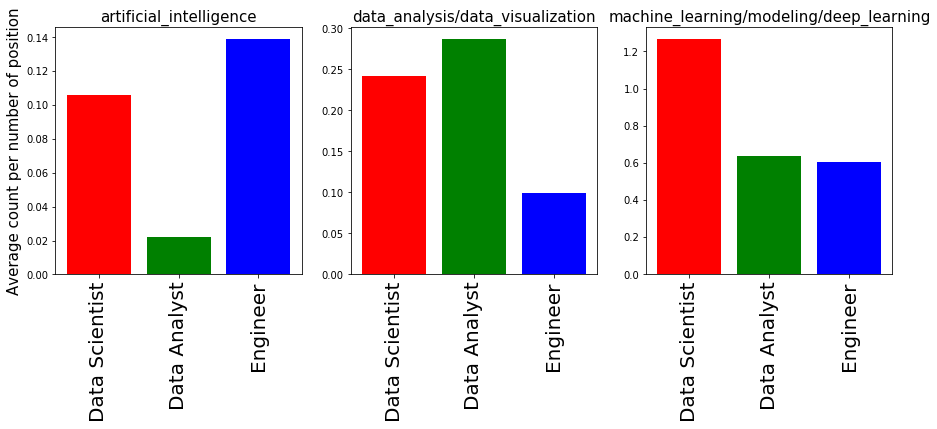

In [160]:
from matplotlib.gridspec import GridSpec

# Make square figures and axes
plt.figure(1, figsize=(15,10))
the_grid = GridSpec(2, 3)
index = np.arange(3)
my_colors = 'rgbkymc'

ax=plt.subplot(the_grid[0, 0])
plt.bar(index, df1['artificial_intelligence'], align='center', color=my_colors)
plt.xticks(index, ['Data Scientist', 'Data Analyst', 'Engineer'], rotation=90, fontsize=20)
plt.ylabel('Average count per number of position', fontsize=15)
ax.set_title('artificial_intelligence',fontsize= 15) 

ax=plt.subplot(the_grid[0, 1], title='data_analysis/data_visualization')
plt.bar(index, df1['data_analysis/data_visualization'], align='center', color=my_colors)
plt.xticks(index, ['Data Scientist', 'Data Analyst', 'Engineer'], rotation=90, fontsize=20)
ax.set_title('data_analysis/data_visualization',fontsize= 15) 

ax=plt.subplot(the_grid[0, 2], title='machine_learning/modeling/deep_learning')
plt.bar(index, df1['machine_learning/modeling/deep_learning'], align='center', color=my_colors)
plt.xticks(index, ['Data Scientist', 'Data Analyst', 'Engineer'], rotation=90, fontsize=20)
ax.set_title('machine_learning/modeling/deep_learning',fontsize= 15)

#plt.suptitle('Skills Requirements for Three Job Types', fontsize=16)
plt.show()

# Tools vs Job Type

In [109]:
tool_list = ['python','sql','java','scala','excel',
               'aws','hadoop','spark','linux','tableau','sas',
               'linux','sas','hive','oracle','perl',
               'mysql','matlab','html','tensorflow','spss','mongodb','r']

regexTokenizer = Tokenizer(inputCol="description", outputCol="words")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df_new3_clean2)
dataset = pipelineFit.transform(df_new3_clean2)

terms_ds=dataset.filter(col('position2') == 'Data Scientist').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

terms_da=dataset.filter(col('position2') == 'Data Analyst').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)

terms_e=dataset.filter(col('position2') == 'Engineer').withColumn('TermFre', explode(col('filtered')))\
                                                            .groupBy('TermFre')\
                                                            .count()
                                                            #.sort('count', ascending=False)
    
# skill_list ranking
pandas_df1=terms_ds.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(tool_list) + ')(\s|$)')).toPandas()
pandas_df2=terms_da.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(tool_list) + ')(\s|$)')).toPandas()
pandas_df3=terms_e.filter(col('TermFre').rlike('(^|\s)(' + '|'.join(tool_list) + ')(\s|$)')).toPandas()

In [110]:
import pandas as pd
df_joined = pd.merge(pandas_df1, pandas_df2, on='TermFre', how='outer')
df_joined1 = pd.merge(df_joined, pandas_df3, on='TermFre', how='outer')

In [112]:
df_joined1.columns=['Tools', 'Data Scientist', 'Data Analyst', 'Engineer']
df_joined1.sort_values(by=['Data Scientist'], inplace=True)

In [114]:
df_joined1['Data Scientist']=df_joined1['Data Scientist']/2884
df_joined1['Data Analyst']=df_joined1['Data Analyst']/993
df_joined1['Engineer']=df_joined1['Engineer']/1151
df_joined1

Tools  Data Scientist  Data Analyst  Engineer
2         html        0.007628      0.016113  0.042572
4      mongodb        0.019071      0.009063  0.031277
7        mysql        0.022538      0.022155  0.059079
19      oracle        0.028433      0.050352  0.045178
0         spss        0.031207      0.087613  0.002606
3         perl        0.059293      0.029204  0.063423
11       linux        0.079404      0.035247  0.197220
1   tensorflow        0.086685      0.003021  0.104257
5      tableau        0.086685      0.215509  0.033015
6        excel        0.089459      0.454179  0.059948
15         aws        0.096047      0.084592  0.349262
9        scala        0.107143      0.020141  0.184188
17      matlab        0.111650      0.070493  0.097307
20        hive        0.116505      0.047331  0.110339
12         sas        0.148405      0.217523  0.026064
16      hadoop        0.214632      0.063444  0.290182
13        java        0.219834      0.089627  0.463076
10       spark        0.220874      0.052367  0.339705
8          sql        0.361997      0.470292  0.327541
14           r        0.492718      0.388721  0.131190
18      python        0.687240      0.374622  0.682016

Text(0.5,0,'Average count per number of position')

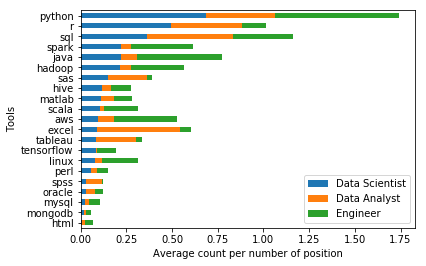

In [119]:
ax = df_joined1.plot.barh(df_joined1['Tools'], stacked = True)
ax.set_xlabel("Average count per number of position")